In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from pathlib import Path
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *


pio.renderers.default = "iframe"

In [2]:
base_path = "/data/saturation/central_composite_design/ccd4"
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]
stats_df = pd.read_csv(f"{base_path}/post_saturation_statistics_corners.csv")

### Linear regression model

In [3]:
def fit_and_report_model(model, data, dependent_variable, model_name):
    # X = data[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].copy()
    X = data.drop([dependent_variable], axis=1)
    y = data[dependent_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model_fit = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"{model_name}: Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")
    
    residuals = y_train - y_pred
    plt.hist(residuals)
    
    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    print(f"{model_name}: Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")
    
    y_pred_mean_model = [y_train.mean()] * len(y_test)
    rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
    print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model_fit

#### Checking scatterplots

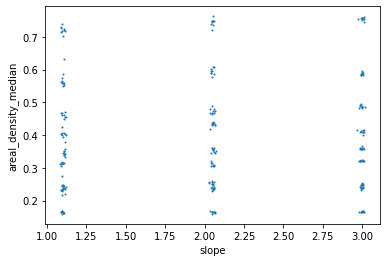

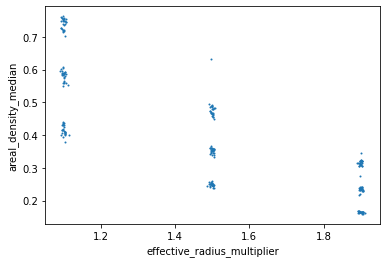

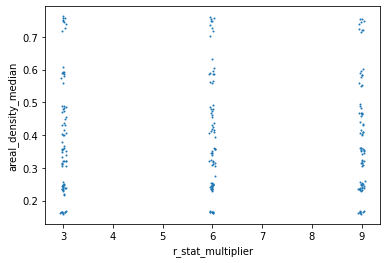

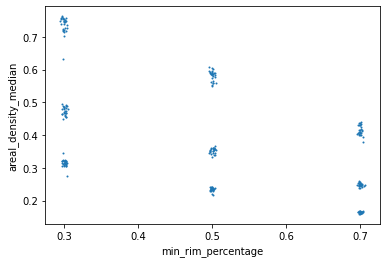

In [4]:
metric = "areal_density_median"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

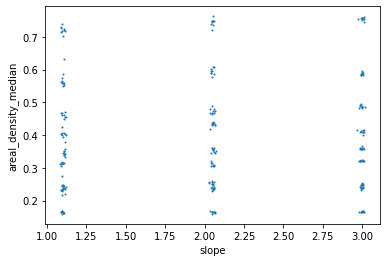

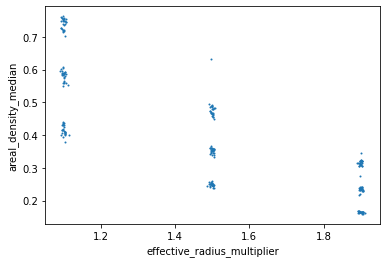

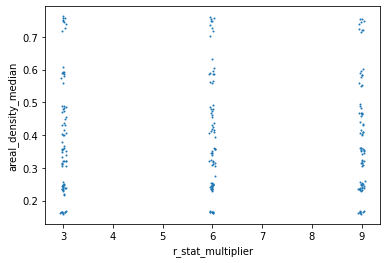

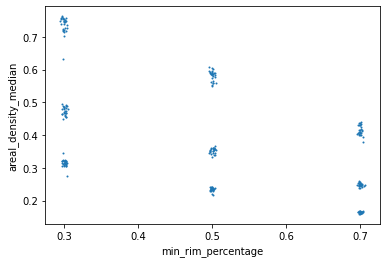

In [5]:
metric = "areal_density_median"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

In [6]:
# Model with no interactions
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[ivs]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.948
Model:                              OLS   Adj. R-squared:                  0.948
Method:                   Least Squares   F-statistic:                     1094.
Date:                  Sun, 29 Jan 2023   Prob (F-statistic):          7.05e-152
Time:                          13:17:20   Log-Likelihood:                 440.55
No. Observations:                   243   AIC:                            -871.1
Df Residuals:                       238   BIC:                            -853.6
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.3125      0.017     76.935      0.000       1.279       1.346
slope                           0.0067      0.003      2.033      0.043       0.000       0.013
effective_radius_multiplier    -0.4258      0.008    -54.346      0.000      -0.441      -0.410
r_stat_multiplier            -4.97e-05      0.001     -0.048      0.962      -0.002       0.002
min_rim_percentage             -0.5895      0.016    -37.600      0.000      -0.620      -0.559
==============================================================================
Omnibus:                       36.431   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.079
Skew:                           0.622   Prob(JB):                     9.74e-06
Kurtosis:                       2.146   Cond. No.                         55.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Dropping r_stat_multiplier
exclude = {
    "r_stat_multiplier"
}
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[x for x in ivs if x not in exclude]]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.948
Model:                              OLS   Adj. R-squared:                  0.948
Method:                   Least Squares   F-statistic:                     1465.
Date:                  Sun, 29 Jan 2023   Prob (F-statistic):          1.70e-153
Time:                          13:17:21   Log-Likelihood:                 440.55
No. Observations:                   243   AIC:                            -873.1
Df Residuals:                       239   BIC:                            -859.1
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.3122      0.016     82.879      0.000       1.281       1.343
slope                           0.0067      0.003      2.037      0.043       0.000       0.013
effective_radius_multiplier    -0.4258      0.008    -54.460      0.000      -0.441      -0.410
min_rim_percentage             -0.5895      0.016    -37.679      0.000      -0.620      -0.559
==============================================================================
Omnibus:                       36.396   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.097
Skew:                           0.623   Prob(JB):                     9.65e-06
Kurtosis:                       2.147   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Adding degree 2 polynomial features
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2)
X = poly_transform.fit_transform(stats_df[ivs])
X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
X[metric] = stats_df[metric]

In [9]:
# All polynomial features
exclude = {
    metric,
}
model = sm.OLS(stats_df[metric], sm.add_constant(X[[x for x in X.columns if x not in exclude]]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.994
Model:                              OLS   Adj. R-squared:                  0.994
Method:                   Least Squares   F-statistic:                     2788.
Date:                  Sun, 29 Jan 2023   Prob (F-statistic):          4.41e-246
Time:                          13:17:22   Log-Likelihood:                 705.92
No. Observations:                   243   AIC:                            -1382.
Df Residuals:                       228   BIC:                            -1329.
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
1                                                  2.3312      0.037     63.599      0.000       2.259       2.403
slope                                              0.0529      0.011      4.821      0.000       0.031       0.074
effective_radius_multiplier                       -1.5890      0.037    -42.753      0.000      -1.662      -1.516
r_stat_multiplier                                 -0.0005      0.003     -0.152      0.879      -0.007       0.006
min_rim_percentage                                -1.4796      0.056    -26.299      0.000      -1.590      -1.369
slope^2                                           -0.0058      0.002     -2.801      0.006      -0.010      -0.002
slope effective_radius_multiplier                 -0.0091      0.003     -2.635      0.009      -0.016      -0.002
slope r_stat_multiplier                        -9.737e-05      0.000     -0.210      0.834      -0.001       0.001
slope min_rim_percentage                          -0.0162      0.007     -2.342      0.020      -0.030      -0.003
effective_radius_multiplier^2                      0.3004      0.012     25.850      0.000       0.278       0.323
effective_radius_multiplier r_stat_multiplier      0.0015      0.001      1.384      0.168      -0.001       0.004
effective_radius_multiplier min_rim_percentage     0.5434      0.016     33.036      0.000       0.511       0.576
r_stat_multiplier^2                               -0.0002      0.000     -1.002      0.317      -0.001       0.000
r_stat_multiplier min_rim_percentage               0.0018      0.002      0.828      0.409      -0.003       0.006
min_rim_percentage^2                               0.0981      0.047      2.107      0.036       0.006       0.190
==============================================================================
Omnibus:                      371.639   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77565.133
Skew:                           7.224   Prob(JB):                         0.00
Kurtosis:                      89.325   Cond. No.                     4.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# After stepwise predictor elimination of features with insignificant p-values
exclude = {
    metric,
    "r_stat_multiplier min_rim_percentage",
    "effective_radius_multiplier r_stat_multiplier",
    "r_stat_multiplier^2",
    "slope r_stat_multiplier",
    "r_stat_multiplier",
    "min_rim_percentage^2",
    "slope min_rim_percentage"
}
model = sm.OLS(stats_df[metric], sm.add_constant(X[[x for x in X.columns if x not in exclude]]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.994
Model:                              OLS   Adj. R-squared:                  0.994
Method:                   Least Squares   F-statistic:                     5421.
Date:                  Sun, 29 Jan 2023   Prob (F-statistic):          7.91e-256
Time:                          13:17:22   Log-Likelihood:                 698.86
No. Observations:                   243   AIC:                            -1382.
Df Residuals:                       235   BIC:                            -1354.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
1                                                  2.3146      0.032     73.396      0.000       2.253       2.377
slope                                              0.0442      0.010      4.350      0.000       0.024       0.064
effective_radius_multiplier                       -1.5804      0.037    -42.608      0.000      -1.653      -1.507
min_rim_percentage                                -1.4044      0.026    -54.869      0.000      -1.455      -1.354
slope^2                                           -0.0058      0.002     -2.768      0.006      -0.010      -0.002
slope effective_radius_multiplier                 -0.0091      0.004     -2.603      0.010      -0.016      -0.002
effective_radius_multiplier^2                      0.3005      0.012     25.504      0.000       0.277       0.324
effective_radius_multiplier min_rim_percentage     0.5437      0.017     32.596      0.000       0.511       0.577
==============================================================================
Omnibus:                      351.051   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59743.988
Skew:                           6.545   Prob(JB):                         0.00
Kurtosis:                      78.692   Cond. No.                         424.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""